In [1]:
# Import Numpy and Matplotlib
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

# Other Imports
import random
import pandas as pd
import statistics
import math
import time

# Scipy
from scipy import optimize, stats

# Astropy
from astropy.timeseries import LombScargle

from scipy.fft import fft

from operator import itemgetter

In [2]:
# Read the Data Cube
noon_cube = np.load('data_cube_v2.0.0.npy',allow_pickle='TRUE').item()

In [3]:
# Organize and Make Datetimes Readable
datetimes = []
for x in noon_cube:
    x = x.replace('Time ', '')
    datetimes.append(x)
datetimes.sort()

import datetime
formatted_dates = []
datetimes.remove('20210509T195226')
np_datetimes = np.array(datetimes)
for datetime_value in np_datetimes:
    d = datetime.datetime.strptime(datetime_value, '%Y%m%dT%H%M%S')
    formatted_dates.append(d)
dates = mdates.date2num(formatted_dates)

In [4]:
# Universal Graph Styling
COLOR = 'k'
plt.style.use(['ggplot'])
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams.update({'figure.max_open_warning': 0})

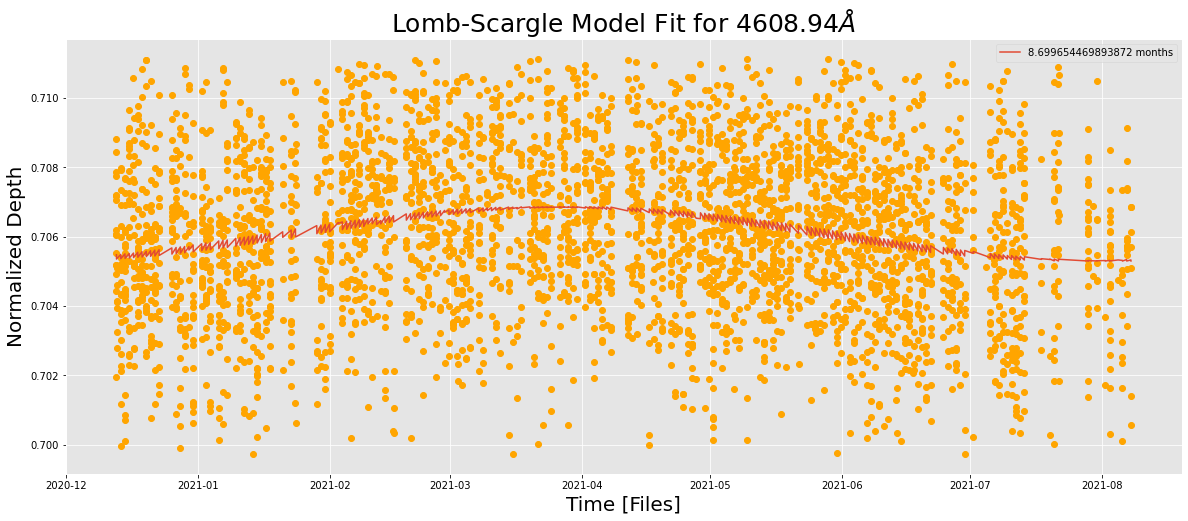

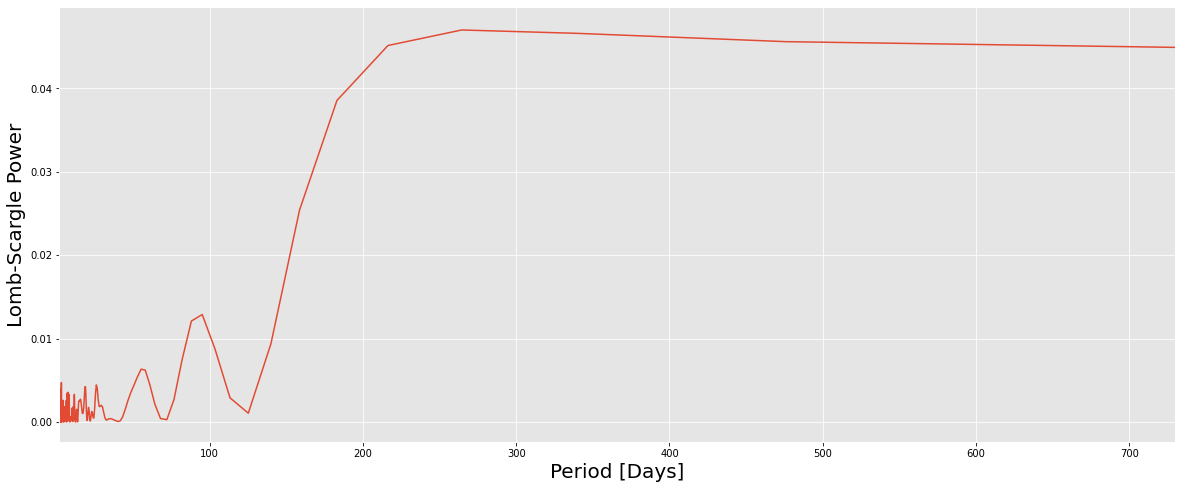

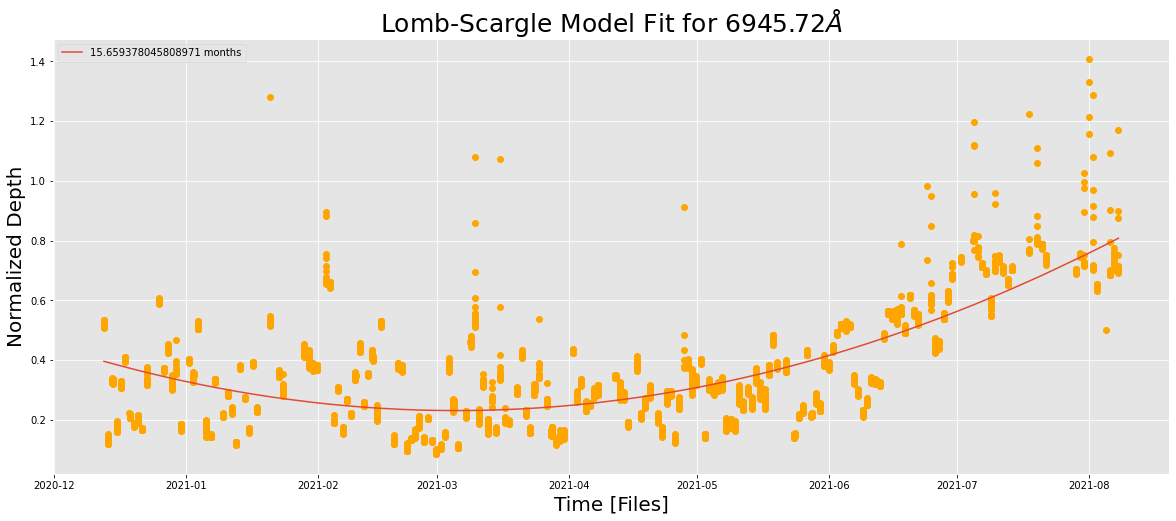

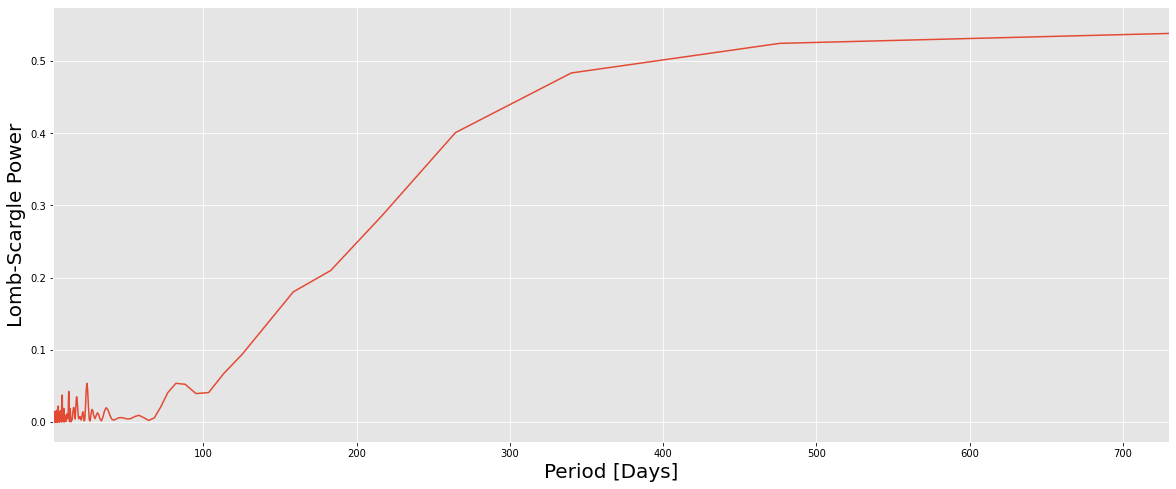

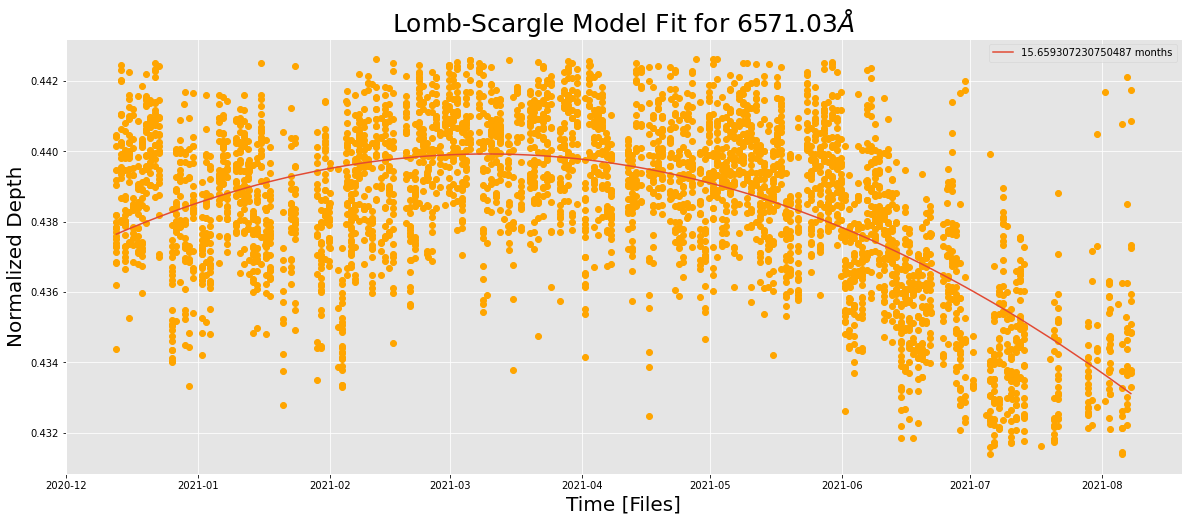

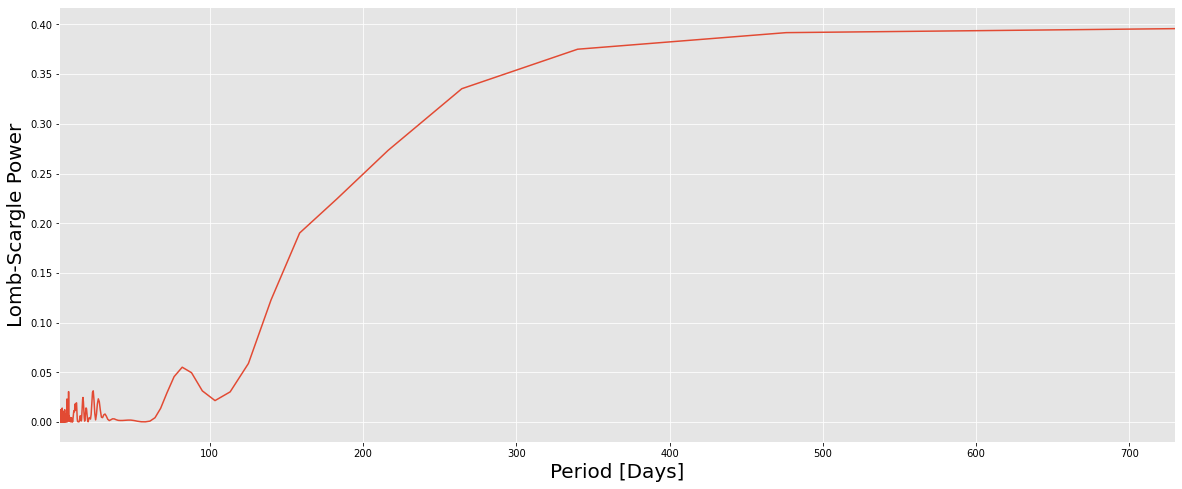

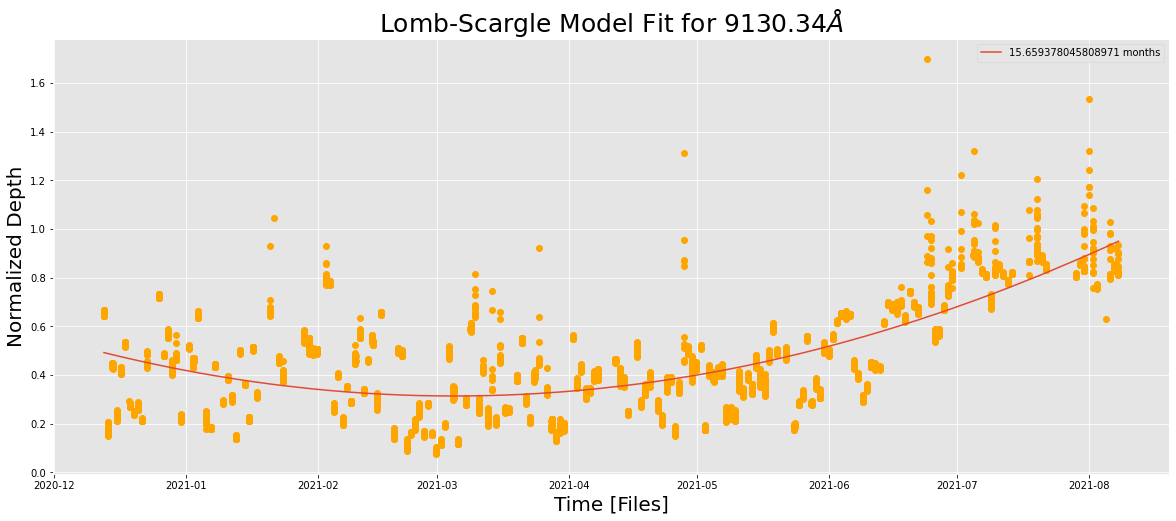

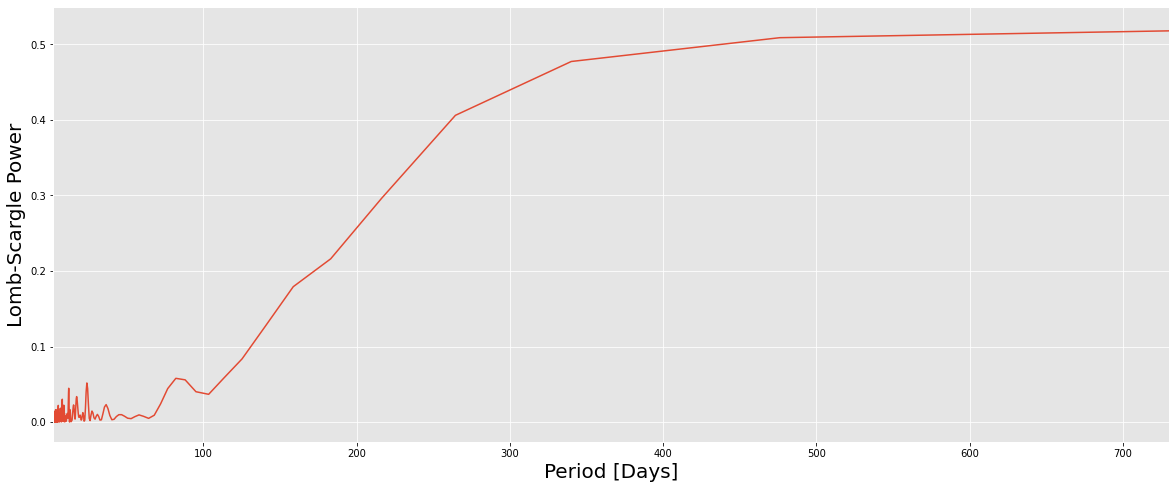

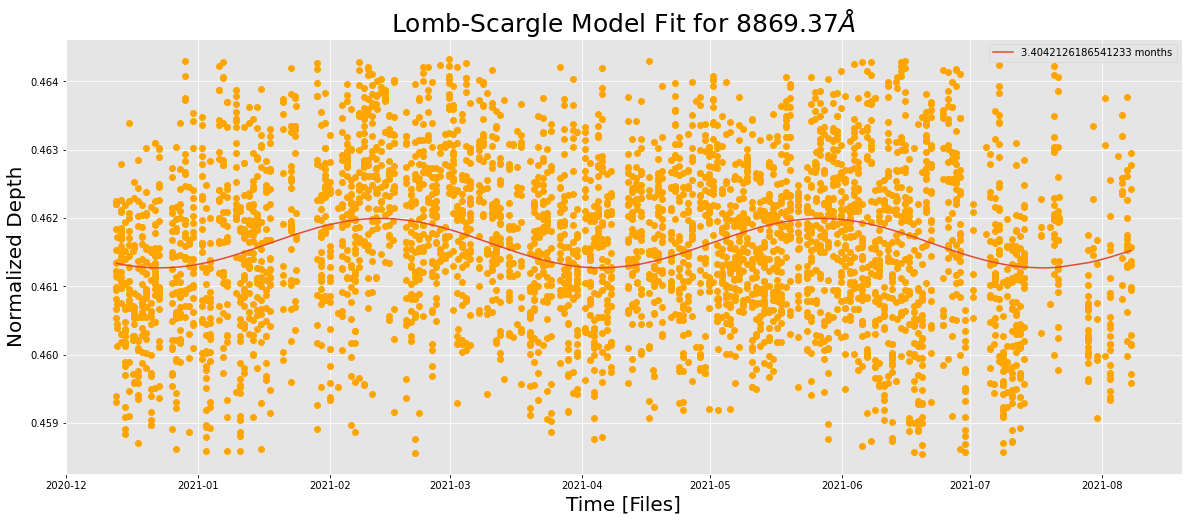

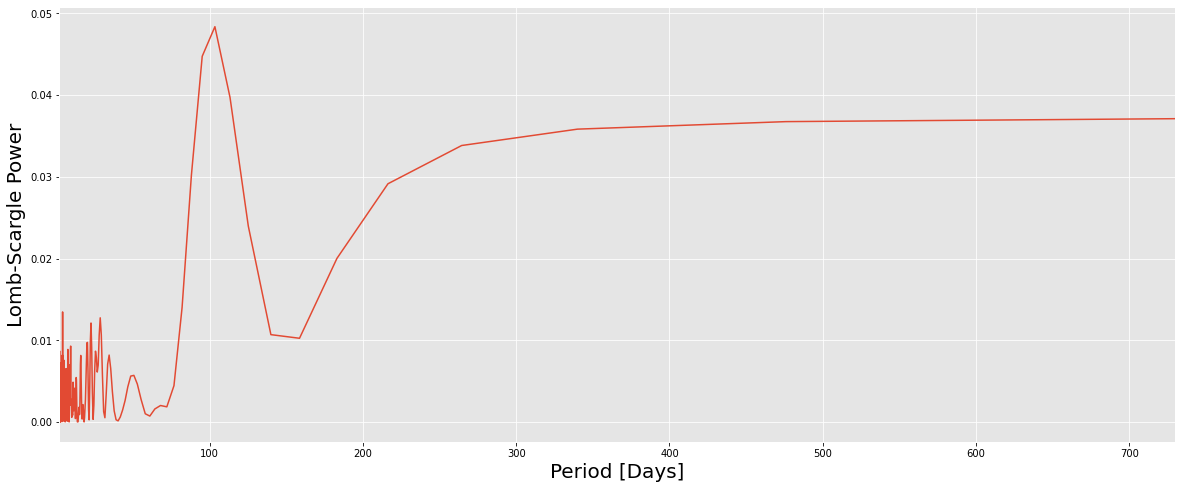

In [6]:
# Generate 5 Random Lines to Experiment with Fitting
for _ in range(5):
    
    # Choose Random Line
    random_file = random.choice(list(noon_cube))
    random_order = random.choice(list(noon_cube[random_file]))
    random_line = random.choice(list(noon_cube[random_file][random_order]))

    # Get all Depth Values over Time
    dl = []
    for datetime in datetimes:
        datetime = 'Time '+datetime
        try:
            depth = noon_cube[datetime][random_order][random_line]['amplitude']
            centroid = noon_cube[datetime][random_order][random_line]['centroid']
        except KeyError:
            depth = 0
            centroid = 0
        dl.append((depth, centroid)) 
    dl_depths = np.asarray(list(zip(*dl))[0])
    line = str(round(dl[1][1], 2))

    # Pandas DF and Filtering
    df = pd.DataFrame(zip(dl_depths, dates))
    df = df[df[0] != 0]
    #df = df[(np.abs(stats.zscore(df)) < 2.5).all(axis=1)]
    
    variance = statistics.variance(df[0]) * 100
    med = np.median(df[0])
    med_up = med + 0.03
    med_down = med - 0.03
    
    if variance < 1:
        df = df[df[0] < med_up]
        df = df[df[0] > med_down]
        q_hi = df[0].quantile(0.96)
        q_low = df[0].quantile(0.01)
        df = df[(df[0] < q_hi) & (df[0] > q_low)]
    t,y = df[1].to_numpy(), df[0].to_numpy()
    
    # Datetimes for each Generation
    import datetime
    formatted_dates = []
    for datetime_value in np_datetimes:
        d = datetime.datetime.strptime(datetime_value, '%Y%m%dT%H%M%S')
        formatted_dates.append(d)
    dates = mdates.date2num(formatted_dates)
    
    # Create Fit (for Model Plotting)
    frequency, power = LombScargle(t, y).autopower(maximum_frequency=1000)
    best_frequency = frequency[np.argmax(power)]
    ls = LombScargle(t, y)
    y_fit = ls.model(t, best_frequency)  
    
    # Undo the Matplotlib Date Formatting
    undo_formatting = mdates.num2date(t)
    
    # New Format (Seconds since Jan 1, 1970)
    seconds = []
    for j in undo_formatting:
        s = time.mktime(j.timetuple())
        seconds.append(s)
    
    # Final Format (Seconds in relation to 1st val in list (0.0s))
    first = seconds[0]
    for i in range(len(seconds)):
        seconds[i] = seconds[i] - first
    
    # Create Fit (for Lomb-Scargle Plot)
    freq2, pwr2 = LombScargle(seconds, y).autopower()
    periods = [(((1 / x) / 3600) / 24) for x in freq2]
    pair = [[x, y] for x, y in zip(pwr2, periods)]
    L2 = [n for n in pair if ((n[1] > 2) & (n[1] < 730))]
    
    list1, list2 = zip(*L2)
    L2_dict = dict(L2)
    power_max = max(list1)
    best_period_days = L2_dict[power_max]
    best_period_months = best_period_days / 30.4
    
    # L2 is formatted ([x, y], [x, y]), Get x value where y value peaks in L2
    # pls Nidhi Overflow

    # Plot
    plt.figure(figsize=(20,8))
    plt.plot_date(df[1], df[0], color='orange')
    plt.plot(df[1], y_fit, label=str(best_period_months)+" months")
    plt.title('Lomb-Scargle Model Fit for '+str(line)+'$\AA$', fontsize=25)
    plt.xlabel('Time [Files]', fontsize=20)
    plt.ylabel('Normalized Depth', fontsize=20)
    plt.legend()
    
    plt.figure(figsize=(20,8))
    plt.plot(periods, pwr2)
    plt.xlim(2,730) # 1 day to 8 months
    plt.xlabel('Period [Days]', fontsize=20)
    plt.ylabel('Lomb-Scargle Power', fontsize=20)

In [7]:
# Frequency Machine
orders = list(range(40,111))
freq_data = []
for order in orders:
    for line in noon_cube['Time 20210509T195226']['Order '+str(order)]:   
        # Get all Depth Values over Time
        dl = []
        for datetime in datetimes:
            datetime = 'Time '+datetime
            try:
                depth = noon_cube[datetime]['Order '+str(order)][line]['amplitude']
                centroid = noon_cube[datetime]['Order '+str(order)][line]['centroid']
            except KeyError:
                depth = 0
                centroid = 0
            dl.append((depth, centroid)) 
        dl_depths = np.asarray(list(zip(*dl))[0])
        linia = str(round(dl[1][1], 2))
        
        # Pandas DF and Filtering
        df = pd.DataFrame(zip(dl_depths, dates))
        df = df[df[0] != 0]
        #df = df[(np.abs(stats.zscore(df)) < 2.5).all(axis=1)]

        variance = statistics.variance(df[0]) * 100
        med = np.median(df[0])
        med_up = med + 0.03
        med_down = med - 0.03

        if variance < 1:
            df = df[df[0] < med_up]
            df = df[df[0] > med_down]
            q_hi = df[0].quantile(0.96)
            q_low = df[0].quantile(0.01)
            df = df[(df[0] < q_hi) & (df[0] > q_low)]
        t,y = df[1].to_numpy(), df[0].to_numpy()
        
        # Datetimes for each Generation
        import datetime
        formatted_dates = []
        for datetime_value in np_datetimes:
            d = datetime.datetime.strptime(datetime_value, '%Y%m%dT%H%M%S')
            formatted_dates.append(d)
        dates = mdates.date2num(formatted_dates) 

        # Undo the Matplotlib Date Formatting
        undo_formatting = mdates.num2date(t)
        
        # New Format (Seconds since Jan 1, 1970)
        seconds = []
        for j in undo_formatting:
            s = time.mktime(j.timetuple())
            seconds.append(s)

        # Final Format (Seconds in relation to 1st val in list (0.0s))
        first = seconds[0]
        for i in range(len(seconds)):
            seconds[i] = seconds[i] - first
            
        # Create Fit (for Lomb-Scargle Plot)
        freq2, pwr2 = LombScargle(seconds, y).autopower()
        periods = [(((1 / x) / 3600) / 24) for x in freq2]
        pair = [[x, y] for x, y in zip(pwr2, periods)]
        L2 = [n for n in pair if ((n[1] > 2) & (n[1] < 730))]

        list1, list2 = zip(*L2)
        L2_dict = dict(L2)
        power_max = max(list1)
        best_period_days = L2_dict[power_max]
        best_period_months = best_period_days / 30.4

        frequency_in_nHz = (1 / (best_period_months * 30.4 * 86400)) * 1000000000
        
        freq_data.append((frequency_in_nHz, linia, power_max))

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

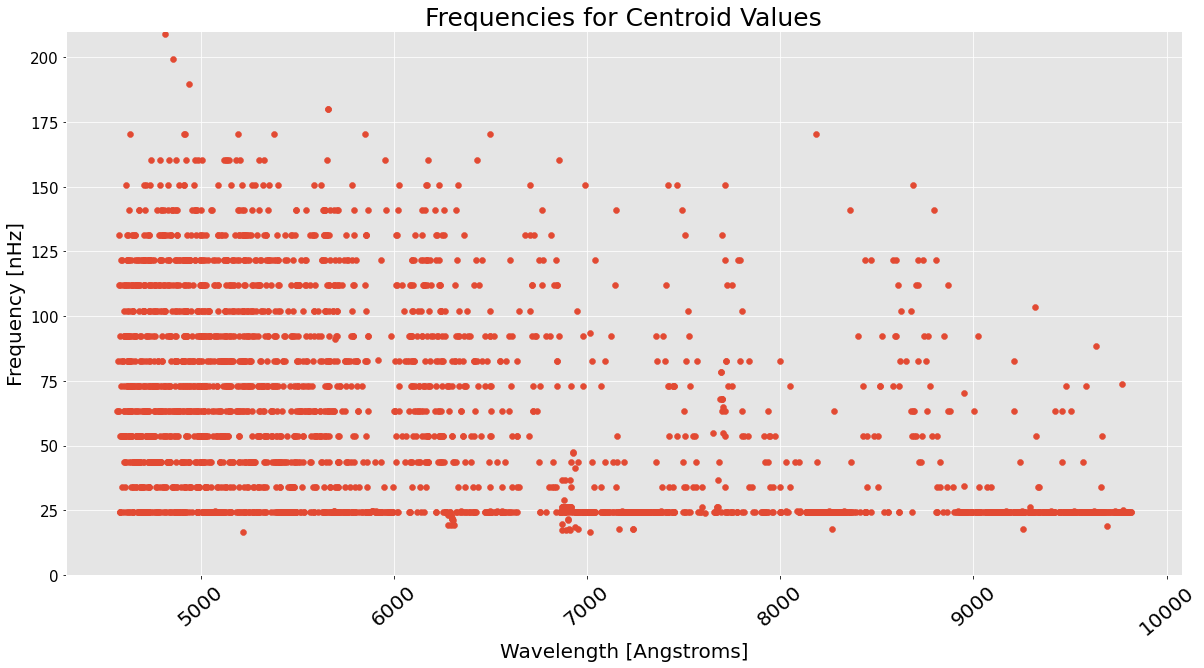

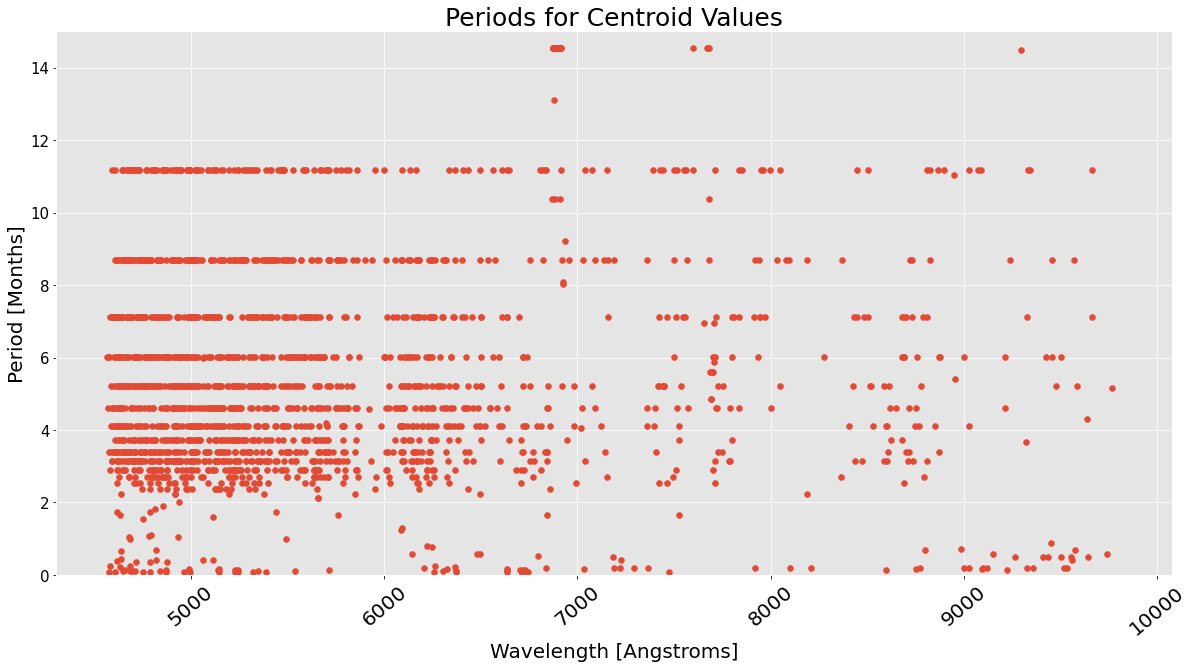

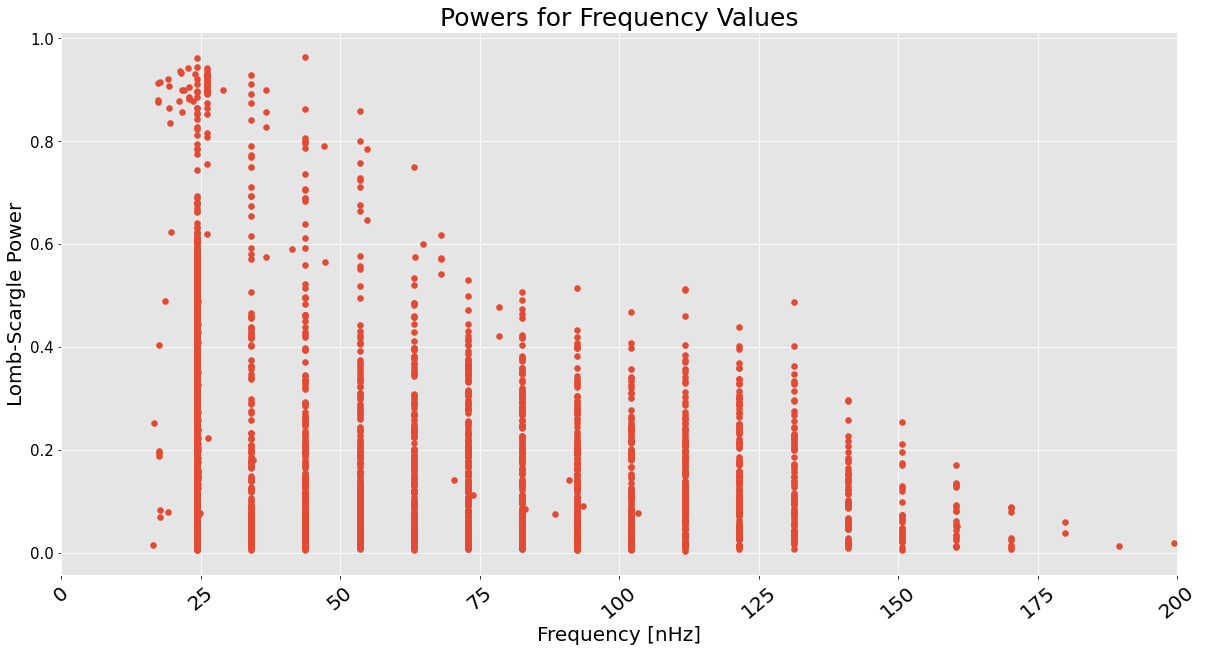

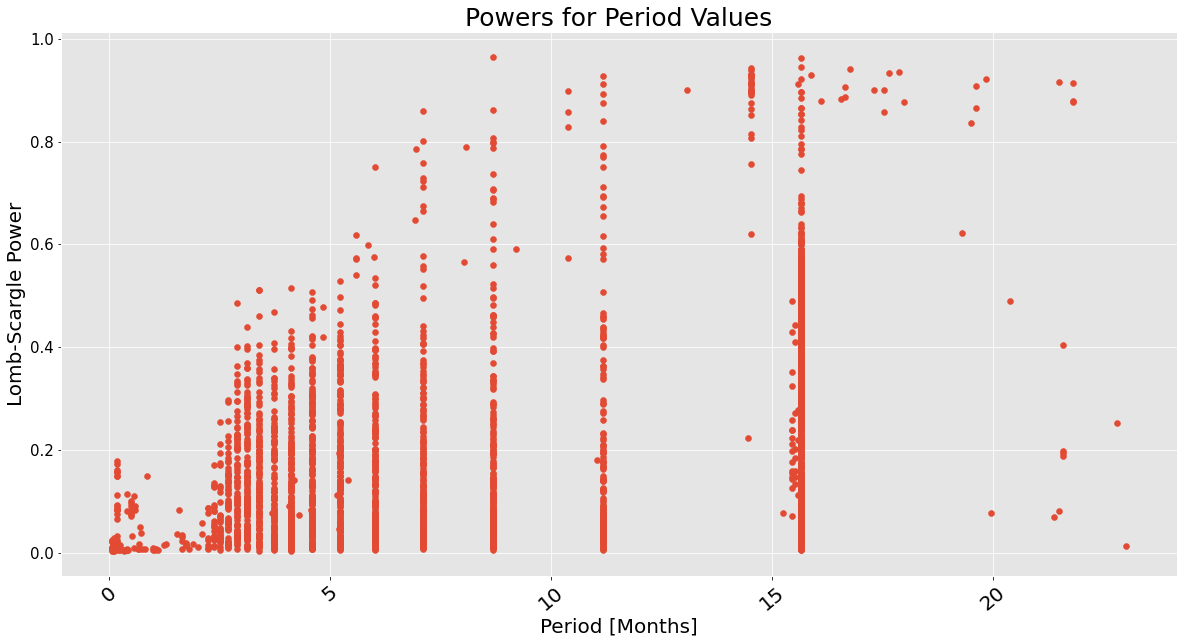

In [42]:
# Prepare values for Plotting
centroids = list(zip(*freq_data))[1]
freqs = list(zip(*freq_data))[0]
pwrs = list(zip(*freq_data))[2]

periods = []
for n in freqs:
    periods.append(((1000000000 / n) / 30.4) / 86400)

# Grabbing Text File Data
pre_centroids = np.array([x.split(' ')[0] for x in open("G2_espresso.txt").readlines()])
pre_depths = list(np.array([x.split(' ')[1] for x in open("G2_espresso.txt").readlines()]))
pre_depths = [item.replace("\n", "") for item in pre_depths] 

# Prepare Text Values for Plotting
txt_centroids = []
txt_depths = []
for x in pre_centroids:
    txt_centroids.append(float(x))
for x in pre_depths:
    txt_depths.append(float(x))
    
cents = []
for x in centroids:
    cents.append(float(x))

# Frequency[nHz] v. Centroids[Angstroms]
plt.figure(figsize=(20,10))
plt.scatter(cents, freqs)
plt.title('Frequencies for Centroid Values', fontsize=25)
plt.ticklabel_format(useOffset=False)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Frequency [nHz]', fontsize=20)
plt.xticks(fontsize=20, rotation=40)
plt.ylim((0, 210))
plt.yticks(fontsize=15)

# Periods[Months] v. Centroids[Angstroms]
plt.figure(figsize=(20,10))
plt.scatter(cents, periods)
plt.title('Periods for Centroid Values', fontsize=25)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Period [Months]', fontsize=20)
plt.xticks(fontsize=20, rotation=40)
plt.ylim((0, 15))
plt.yticks(fontsize=15)

# Lomb-Scargle Power v. Frequency[nHz]
plt.figure(figsize=(20,10))
plt.scatter(freqs, pwrs)
plt.title('Powers for Frequency Values', fontsize=25)
plt.xlabel('Frequency [nHz]', fontsize=20)
plt.ylabel('Lomb-Scargle Power', fontsize=20)
plt.xticks(fontsize=20, rotation=40)
plt.xlim((0,200))
plt.yticks(fontsize=15)

# Lomb-Scargle Power v. Period[Months]
plt.figure(figsize=(20,10))
plt.scatter(periods, pwrs)
plt.title('Powers for Period Values', fontsize=25)
plt.xlabel('Period [Months]', fontsize=20)
plt.ylabel('Lomb-Scargle Power', fontsize=20)
plt.xticks(fontsize=20, rotation=40)
plt.yticks(fontsize=15)

In [43]:
import pickle
with open("centroids.txt", "wb") as fp: 
    pickle.dump(centroids, fp)
    
with open("freqs.txt", "wb") as fp:  
    pickle.dump(freqs, fp)
    
with open("pwrs.txt", "wb") as fp:  
    pickle.dump(pwrs, fp)